In [17]:
# Importando as bibliotecas necessárias
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt
from matplotlib.image import imread

### Parte 1: Carregando e configurando o modelo pré-treinado


Aqui utilizamos o modelo VGG16 pré-treinado para extração de características das imagens
O VGG16 foi escolhido por sua eficácia em tarefas de classificação de imagens.

In [9]:
model = VGG16(weights='imagenet', include_top=False)

# Função para extrair os vetores de características de uma imagem
def extract_features(image_path, model):
    """
    Extrai características de uma imagem usando o modelo VGG16.
    
    Parâmetros:
    - image_path: caminho para a imagem
    - model: modelo de rede neural pré-treinado
    
    Retorna:
    - Vetor normalizado de características extraídas da imagem
    """
    # Carrega a imagem e a redimensiona para 224x224, como requerido pelo VGG16
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)  # Converte a imagem para um array NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)  # Pré-processa a imagem

    # Extrai as características
    features = model.predict(img_array)
    features = features.flatten()  # Achata o array para 1D
    features = normalize([features])  # Normaliza o vetor
    return features[0]



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


### Parte 2: Indexando imagens do banco de dados

In [13]:
# Aqui indexamos as imagens em um diretório organizado por classes
image_directory = "dataset"
image_features = {}
image_classes = {}

# Itera sobre as subpastas (classes) no diretório de imagens
for class_name in os.listdir(image_directory):
    class_path = os.path.join(image_directory, class_name)
    if os.path.isdir(class_path):  # Certifique-se de que é um diretório (classe)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            if os.path.isfile(image_path) and image_name.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):  # Certifique-se de que é uma imagem
                features = extract_features(image_path, model)
                if features is not None:  # Apenas adiciona se a extração foi bem-sucedida
                    image_features[image_name] = features
                    image_classes[image_name] = class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

### Parte 3: Sistema de recomendação por similaridade de imagens

In [14]:
# Função para recomendar imagens com base em uma imagem de consulta
def recommend_similar_images(query_image_path, image_features, image_classes, top_n=5):
    """
    Recomenda imagens semelhantes com base em uma imagem de consulta.
    
    Parâmetros:
    - query_image_path: caminho para a imagem de consulta
    - image_features: dicionário com os vetores de características das imagens indexadas
    - image_classes: dicionário que associa imagens às suas classes
    - top_n: número de imagens mais semelhantes a retornar
    
    Retorna:
    - Lista de nomes e classes das imagens mais semelhantes
    """
    query_features = extract_features(query_image_path, model)
    if query_features is None:
        print("Erro: Não foi possível extrair características da imagem de consulta.")
        return []

    similarities = {}

    # Calcula a similaridade por cosseno entre a consulta e as imagens indexadas
    for image_name, features in image_features.items():
        sim = cosine_similarity([query_features], [features])[0][0]
        similarities[image_name] = sim

    # Ordena as imagens pela similaridade e retorna as top_n
    sorted_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return [(image[0], image_classes[image[0]]) for image in sorted_images[:top_n]]

### Parte 4: Testando o sistema de recomendação

Teste Cadernos:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step
Imagens recomendadas:
Imagem: Captura de tela 2025-01-03 151845.png, Classe: cadernos
Imagem: Captura de tela 2025-01-03 151853.png, Classe: cadernos
Imagem: Captura de tela 2025-01-03 151839.png, Classe: cadernos
Imagem: Captura de tela 2025-01-03 151701.png, Classe: cadernos
Imagem: Captura de tela 2025-01-03 151729.png, Classe: cadernos


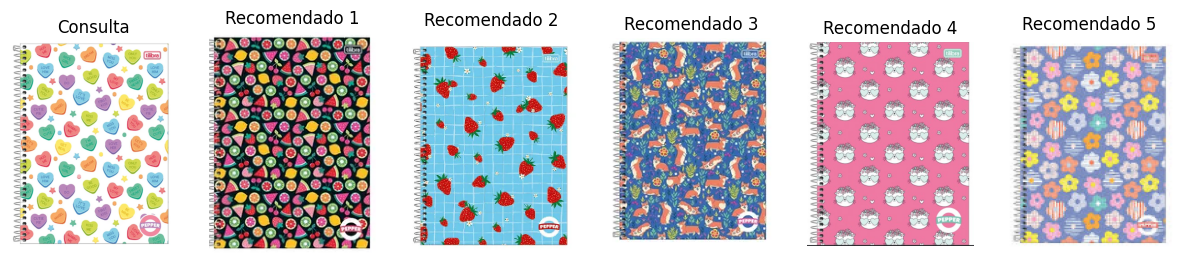

In [18]:
# Defina o caminho para a imagem de consulta
query_image_path = "Test_Caderno.png"

# Recomenda as 5 imagens mais semelhantes
recommended_images = recommend_similar_images(query_image_path, image_features, image_classes, top_n=5)

# Exibe os resultados
print("Imagens recomendadas:")
for img, cls in recommended_images:
    print(f"Imagem: {img}, Classe: {cls}")
    
# Exibe as imagens recomendadas
def plot_images(query_image_path, recommended_images):
    """
    Exibe a imagem de consulta e as imagens recomendadas lado a lado.
    
    Parâmetros:
    - query_image_path: caminho para a imagem de consulta
    - recommended_images: lista de imagens recomendadas
    """
    plt.figure(figsize=(15, 5))

    # Mostra a imagem de consulta
    plt.subplot(1, len(recommended_images) + 1, 1)
    query_img = imread(query_image_path)
    plt.imshow(query_img)
    plt.title("Consulta")
    plt.axis("off")

    # Mostra as imagens recomendadas
    for i, (img_name, _) in enumerate(recommended_images):
        img_path = os.path.join(image_directory, image_classes[img_name], img_name)
        plt.subplot(1, len(recommended_images) + 1, i + 2)
        recommended_img = imread(img_path)
        plt.imshow(recommended_img)
        plt.title(f"Recomendado {i + 1}")
        plt.axis("off")

    plt.show()

plot_images(query_image_path, recommended_images)

Teste Relogio:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Imagens recomendadas:
Imagem: Captura de tela 2025-01-03 151058.png, Classe: relogios
Imagem: Captura de tela 2025-01-03 151031.png, Classe: relogios
Imagem: Captura de tela 2025-01-03 151049.png, Classe: relogios
Imagem: Captura de tela 2025-01-03 151110.png, Classe: relogios
Imagem: Captura de tela 2025-01-03 151103.png, Classe: relogios


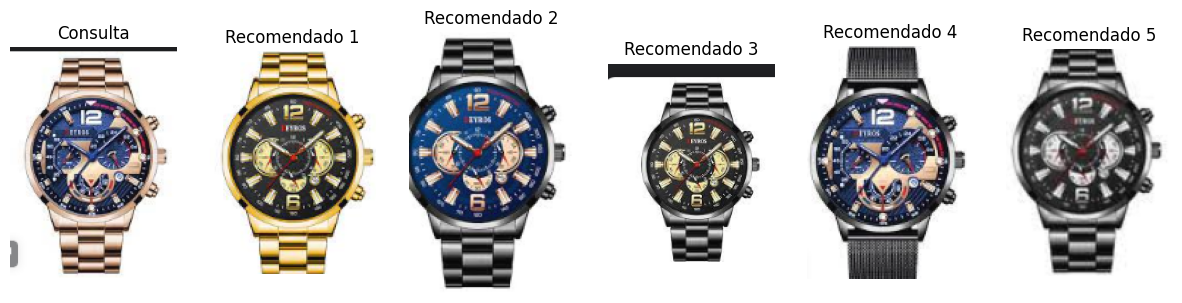

In [19]:
# Defina o caminho para a imagem de consulta
query_image_path = "Test_Relogio.png"

# Recomenda as 5 imagens mais semelhantes
recommended_images = recommend_similar_images(query_image_path, image_features, image_classes, top_n=5)

# Exibe os resultados
print("Imagens recomendadas:")
for img, cls in recommended_images:
    print(f"Imagem: {img}, Classe: {cls}")
    
# Exibe as imagens recomendadas
def plot_images(query_image_path, recommended_images):
    """
    Exibe a imagem de consulta e as imagens recomendadas lado a lado.
    
    Parâmetros:
    - query_image_path: caminho para a imagem de consulta
    - recommended_images: lista de imagens recomendadas
    """
    plt.figure(figsize=(15, 5))

    # Mostra a imagem de consulta
    plt.subplot(1, len(recommended_images) + 1, 1)
    query_img = imread(query_image_path)
    plt.imshow(query_img)
    plt.title("Consulta")
    plt.axis("off")

    # Mostra as imagens recomendadas
    for i, (img_name, _) in enumerate(recommended_images):
        img_path = os.path.join(image_directory, image_classes[img_name], img_name)
        plt.subplot(1, len(recommended_images) + 1, i + 2)
        recommended_img = imread(img_path)
        plt.imshow(recommended_img)
        plt.title(f"Recomendado {i + 1}")
        plt.axis("off")

    plt.show()

plot_images(query_image_path, recommended_images)

Test Smartphone:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Imagens recomendadas:
Imagem: Captura de tela 2025-01-03 152318.png, Classe: smartphones
Imagem: Captura de tela 2025-01-03 152313.png, Classe: smartphones
Imagem: Captura de tela 2025-01-03 152449.png, Classe: smartphones
Imagem: Captura de tela 2025-01-03 152424.png, Classe: smartphones
Imagem: Captura de tela 2025-01-03 152524.png, Classe: smartphones


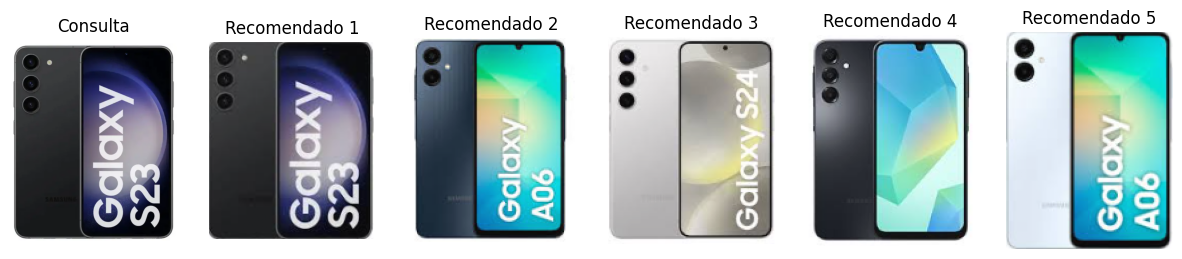

In [20]:
# Defina o caminho para a imagem de consulta
query_image_path = "Test_Smartphone.png"

# Recomenda as 5 imagens mais semelhantes
recommended_images = recommend_similar_images(query_image_path, image_features, image_classes, top_n=5)

# Exibe os resultados
print("Imagens recomendadas:")
for img, cls in recommended_images:
    print(f"Imagem: {img}, Classe: {cls}")
    
# Exibe as imagens recomendadas
def plot_images(query_image_path, recommended_images):
    """
    Exibe a imagem de consulta e as imagens recomendadas lado a lado.
    
    Parâmetros:
    - query_image_path: caminho para a imagem de consulta
    - recommended_images: lista de imagens recomendadas
    """
    plt.figure(figsize=(15, 5))

    # Mostra a imagem de consulta
    plt.subplot(1, len(recommended_images) + 1, 1)
    query_img = imread(query_image_path)
    plt.imshow(query_img)
    plt.title("Consulta")
    plt.axis("off")

    # Mostra as imagens recomendadas
    for i, (img_name, _) in enumerate(recommended_images):
        img_path = os.path.join(image_directory, image_classes[img_name], img_name)
        plt.subplot(1, len(recommended_images) + 1, i + 2)
        recommended_img = imread(img_path)
        plt.imshow(recommended_img)
        plt.title(f"Recomendado {i + 1}")
        plt.axis("off")

    plt.show()

plot_images(query_image_path, recommended_images)